In [86]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# preprocess
from sklearn.preprocessing import LabelEncoder

# model
import lightgbm as lgb

# optimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error as MSE

# other
import pickle
import time
import sys
import gc
import datetime

In [65]:
# set index to ID to avoid droping it later
test  = pd.read_csv('../data/input/test.csv').set_index('ID')

In [66]:
data = pd.read_pickle('../features/data.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694622 entries, 4111216 to 9805837
Data columns (total 39 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_4                  float16
 12  item_cnt_month_lag_5                  float16
 13  item_cnt_month_lag_6                  float16
 14  item_cnt_month_lag_9                  float16
 15  item_cnt_

In [67]:
data.drop(
    [
        'date_shop_type_avg_item_cnt_lag_1',
        'date_shop_subtype_avg_item_cnt_lag_1',
        'date_type_avg_item_cnt_lag_1',
        'date_subtype_avg_item_cnt_lag_1'
    ],
    axis=1,
    inplace=True
)

In [68]:
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

tr_idxes = []
va_idxes = []

# train:2013-01~2015-09
# valid:2015-10
tr_idxes.append(list(data[data.date_block_num < 33].index))
va_idxes.append(list(data[data.date_block_num == 33].index))

# train:2015-09
# valid:2015-10
tr_idxes.append(list(data[data.date_block_num == 32].index))
va_idxes.append(list(data[data.date_block_num == 33].index))

# train:2015-07~2015-09
# valid:2015-10
tr_idxes.append(list(data[(data.date_block_num < 33) & (data.date_block_num > 29)].index))
va_idxes.append(list(data[data.date_block_num == 33].index))

# train:2015-04~2015-09
# valid:2015-10
tr_idxes.append(list(data[(data.date_block_num < 33) & (data.date_block_num > 26)].index))
va_idxes.append(list(data[data.date_block_num == 33].index))

# train:2014-10~2015-09
# valid:2015-10
tr_idxes.append(list(data[(data.date_block_num < 33) & (data.date_block_num > 20)].index))
va_idxes.append(list(data[data.date_block_num == 33].index))

# train:2013-01~2014-10
# valid:2014-11
tr_idxes.append(list(data[data.date_block_num < 22].index))
va_idxes.append(list(data[data.date_block_num == 22].index))

# train:2014-10
# valid:2014-11
tr_idxes.append(list(data[data.date_block_num == 21].index))
va_idxes.append(list(data[data.date_block_num == 22].index))

# train:2014-08~2014-10
# valid:2014-11
tr_idxes.append(list(data[(data.date_block_num < 22) & (data.date_block_num > 18)].index))
va_idxes.append(list(data[data.date_block_num == 22].index))

# train:2014-05~2014-10
# valid:2014-11
tr_idxes.append(list(data[(data.date_block_num < 22) & (data.date_block_num > 15)].index))
va_idxes.append(list(data[data.date_block_num == 22].index))

# train:2013-11~2014-10
# valid:2014-11
tr_idxes.append(list(data[(data.date_block_num < 22) & (data.date_block_num > 9)].index))
va_idxes.append(list(data[data.date_block_num == 22].index))

In [70]:
"""
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

del data
gc.collect();
"""

In [71]:
class Model:

    def __init__(self, params=None):
        self.model = None
        if params is None:
            self.params = {}
        else:
            self.params = params

    def fit(self, tr_x, tr_y, va_x, va_y):
        params.update(self.params)
        num_round = 10
        dtrain = lgb.Dataset(tr_x, tr_y)
        dvalid = lgb.Dataset(va_x, va_y)
        #watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        self.model = lgb.train(
            params, 
            dtrain, 
            num_boost_round=num_round,
            valid_sets=dvalid
        )
        
    def predict(self, x):
        #data = lgb.Dataset(x)
        pred = self.model.predict(x)
        return pred

In [72]:
def score(params):
    params['max_depth'] = int(params['max_depth'])
    
    model = Model(params)
    model.fit(X_train, Y_train, X_valid, Y_valid)
    Y_pred = model.predict(X_valid)
    score = np.sqrt(MSE(y_true=Y_valid, y_pred=Y_pred))
    print(f'params: {params}, score:{score:.4f}')
    
    history.append((params, score))
    return {'loss':score, 'status':STATUS_OK}

In [78]:
params = {
    'objective':'regression',
    #'seed':71,
    'boosting_type':'gbdt',
    'verbosity':-1,
    'metrics':'l2',
    #'min_child_weight':1,
    'max_depth':5,
    'num_leaves':31,
    'num_boost_round':100, 
    #'gamma':0.0,
    #'alpha':0.0,
    #'lambda':1.0,
    'learning_rate':0.1,
    #'feature_fraction':0.9, # colsample_bytree
    #'bagging_fraction':0.8, # subsample
    'bagging_freq':5
}

param_space = {
    'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'bagging_fraction': hp.quniform('bagging_fraction', 0.6, 0.95, 0.05),
    'feature_fraction': hp.quniform('feature_fraction', 0.6, 0.95, 0.05),
    'gamma': hp.quniform('gamma', 0.1, 0.4, 0.1)
    # 余裕があればalpha, lambdaも調整する
    # 'alpha' : hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
    # 'lambda' : hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
}

history = []
best = []

for i in np.arange(len(tr_idxes)):
    X_train = data.loc[tr_idxes[i]].drop(['item_cnt_month'], axis=1)
    Y_train = data.loc[tr_idxes[i]]['item_cnt_month']
    X_valid = data.loc[va_idxes[i]].drop(['item_cnt_month'], axis=1)
    Y_valid = data.loc[va_idxes[i]]['item_cnt_month']
    
    fmin(
        fn=score,
        space=param_space, 
        algo=tpe.suggest, 
        trials=Trials(),
        max_evals=10
    )
    
    history = sorted(history, key=lambda tpl:tpl[1])
    best.append(history[0])

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06898                                                                                              
[2]	valid_0's l2: 1.01997                                                                                              
[3]	valid_0's l2: 0.980791                                                                                             
[4]	valid_0's l2: 0.948881                                                                                             
[5]	valid_0's l2: 0.922638                                                                                             
[6]	valid_0's l2: 0.901281                                                                                             
[7]	valid_0's l2: 0.882805                                                                                             
[8]	valid_0's l2: 0.868205                                                                                             
[9]	valid_0's l2: 0.85746               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07111                                                                                              
[2]	valid_0's l2: 1.02136                                                                                              
[3]	valid_0's l2: 0.981742                                                                                             
[4]	valid_0's l2: 0.948428                                                                                             
[5]	valid_0's l2: 0.922282                                                                                             
[6]	valid_0's l2: 0.899769                                                                                             
[7]	valid_0's l2: 0.881397                                                                                             
[8]	valid_0's l2: 0.865998                                                                                             
[9]	valid_0's l2: 0.854357              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07153                                                                                              
[2]	valid_0's l2: 1.02281                                                                                              
[3]	valid_0's l2: 0.984033                                                                                             
[4]	valid_0's l2: 0.951484                                                                                             
[5]	valid_0's l2: 0.925116                                                                                             
[6]	valid_0's l2: 0.904452                                                                                             
[7]	valid_0's l2: 0.886544                                                                                             
[8]	valid_0's l2: 0.873106                                                                                             
[9]	valid_0's l2: 0.86129               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07072                                                                                              
[2]	valid_0's l2: 1.01981                                                                                              
[3]	valid_0's l2: 0.980104                                                                                             
[4]	valid_0's l2: 0.947069                                                                                             
[5]	valid_0's l2: 0.919745                                                                                             
[6]	valid_0's l2: 0.897981                                                                                             
[7]	valid_0's l2: 0.880031                                                                                             
[8]	valid_0's l2: 0.865215                                                                                             
[9]	valid_0's l2: 0.853853              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06909                                                                                              
[2]	valid_0's l2: 1.01847                                                                                              
[3]	valid_0's l2: 0.979678                                                                                             
[4]	valid_0's l2: 0.946975                                                                                             
[5]	valid_0's l2: 0.920437                                                                                             
[6]	valid_0's l2: 0.898577                                                                                             
[7]	valid_0's l2: 0.880444                                                                                             
[8]	valid_0's l2: 0.865759                                                                                             
[9]	valid_0's l2: 0.854211              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07111                                                                                              
[2]	valid_0's l2: 1.02159                                                                                              
[3]	valid_0's l2: 0.982229                                                                                             
[4]	valid_0's l2: 0.94933                                                                                              
[5]	valid_0's l2: 0.923362                                                                                             
[6]	valid_0's l2: 0.900193                                                                                             
[7]	valid_0's l2: 0.881785                                                                                             
[8]	valid_0's l2: 0.867323                                                                                             
[9]	valid_0's l2: 0.854935              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0694                                                                                               
[2]	valid_0's l2: 1.01923                                                                                              
[3]	valid_0's l2: 0.978685                                                                                             
[4]	valid_0's l2: 0.945649                                                                                             
[5]	valid_0's l2: 0.919479                                                                                             
[6]	valid_0's l2: 0.89816                                                                                              
[7]	valid_0's l2: 0.879789                                                                                             
[8]	valid_0's l2: 0.865224                                                                                             
[9]	valid_0's l2: 0.853068              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06875                                                                                              
[2]	valid_0's l2: 1.02022                                                                                              
[3]	valid_0's l2: 0.980727                                                                                             
[4]	valid_0's l2: 0.949082                                                                                             
[5]	valid_0's l2: 0.922815                                                                                             
[6]	valid_0's l2: 0.900917                                                                                             
[7]	valid_0's l2: 0.882731                                                                                             
[8]	valid_0's l2: 0.868551                                                                                             
[9]	valid_0's l2: 0.856323              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06936                                                                                              
[2]	valid_0's l2: 1.02015                                                                                              
[3]	valid_0's l2: 0.980802                                                                                             
[4]	valid_0's l2: 0.949229                                                                                             
[5]	valid_0's l2: 0.922867                                                                                             
[6]	valid_0's l2: 0.901347                                                                                             
[7]	valid_0's l2: 0.882666                                                                                             
[8]	valid_0's l2: 0.868377                                                                                             
[9]	valid_0's l2: 0.856034              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07128                                                                                              
[2]	valid_0's l2: 1.02208                                                                                              
[3]	valid_0's l2: 0.982359                                                                                             
[4]	valid_0's l2: 0.952371                                                                                             
[5]	valid_0's l2: 0.925152                                                                                             
[6]	valid_0's l2: 0.903931                                                                                             
[7]	valid_0's l2: 0.884702                                                                                             
[8]	valid_0's l2: 0.869236                                                                                             
[9]	valid_0's l2: 0.857553              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06554                                                                                              
[2]	valid_0's l2: 1.01585                                                                                              
[3]	valid_0's l2: 0.975551                                                                                             
[4]	valid_0's l2: 0.94194                                                                                              
[5]	valid_0's l2: 0.915766                                                                                             
[6]	valid_0's l2: 0.892886                                                                                             
[7]	valid_0's l2: 0.876355                                                                                             
[8]	valid_0's l2: 0.861651                                                                                             
[9]	valid_0's l2: 0.849678              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06597                                                                                              
[2]	valid_0's l2: 1.0147                                                                                               
[3]	valid_0's l2: 0.975192                                                                                             
[4]	valid_0's l2: 0.942731                                                                                             
[5]	valid_0's l2: 0.915801                                                                                             
[6]	valid_0's l2: 0.894896                                                                                             
[7]	valid_0's l2: 0.879279                                                                                             
[8]	valid_0's l2: 0.864684                                                                                             
[9]	valid_0's l2: 0.852423              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06432                                                                                              
[2]	valid_0's l2: 1.01378                                                                                              
[3]	valid_0's l2: 0.974288                                                                                             
[4]	valid_0's l2: 0.941399                                                                                             
[5]	valid_0's l2: 0.915663                                                                                             
[6]	valid_0's l2: 0.89574                                                                                              
[7]	valid_0's l2: 0.880313                                                                                             
[8]	valid_0's l2: 0.866825                                                                                             
[9]	valid_0's l2: 0.855772              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0664                                                                                               
[2]	valid_0's l2: 1.01699                                                                                              
[3]	valid_0's l2: 0.97529                                                                                              
[4]	valid_0's l2: 0.942726                                                                                             
[5]	valid_0's l2: 0.915897                                                                                             
[6]	valid_0's l2: 0.894328                                                                                             
[7]	valid_0's l2: 0.878293                                                                                             
[8]	valid_0's l2: 0.864656                                                                                             
[9]	valid_0's l2: 0.853159              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06907                                                                                              
[2]	valid_0's l2: 1.02206                                                                                              
[3]	valid_0's l2: 0.983258                                                                                             
[4]	valid_0's l2: 0.953217                                                                                             
[5]	valid_0's l2: 0.926853                                                                                             
[6]	valid_0's l2: 0.905832                                                                                             
[7]	valid_0's l2: 0.888911                                                                                             
[8]	valid_0's l2: 0.875655                                                                                             
[9]	valid_0's l2: 0.864797              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06434                                                                                              
[2]	valid_0's l2: 1.01394                                                                                              
[3]	valid_0's l2: 0.973617                                                                                             
[4]	valid_0's l2: 0.941499                                                                                             
[5]	valid_0's l2: 0.914306                                                                                             
[6]	valid_0's l2: 0.891969                                                                                             
[7]	valid_0's l2: 0.875587                                                                                             
[8]	valid_0's l2: 0.86224                                                                                              
[9]	valid_0's l2: 0.851299              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0653                                                                                               
[2]	valid_0's l2: 1.01523                                                                                              
[3]	valid_0's l2: 0.974733                                                                                             
[4]	valid_0's l2: 0.941623                                                                                             
[5]	valid_0's l2: 0.914208                                                                                             
[6]	valid_0's l2: 0.893385                                                                                             
[7]	valid_0's l2: 0.876503                                                                                             
[8]	valid_0's l2: 0.861182                                                                                             
[9]	valid_0's l2: 0.848868              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06584                                                                                              
[2]	valid_0's l2: 1.01635                                                                                              
[3]	valid_0's l2: 0.976757                                                                                             
[4]	valid_0's l2: 0.946026                                                                                             
[5]	valid_0's l2: 0.919214                                                                                             
[6]	valid_0's l2: 0.899325                                                                                             
[7]	valid_0's l2: 0.883219                                                                                             
[8]	valid_0's l2: 0.869036                                                                                             
[9]	valid_0's l2: 0.857581              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06467                                                                                              
[2]	valid_0's l2: 1.01412                                                                                              
[3]	valid_0's l2: 0.975153                                                                                             
[4]	valid_0's l2: 0.942313                                                                                             
[5]	valid_0's l2: 0.916038                                                                                             
[6]	valid_0's l2: 0.896381                                                                                             
[7]	valid_0's l2: 0.879477                                                                                             
[8]	valid_0's l2: 0.864123                                                                                             
[9]	valid_0's l2: 0.852345              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07307                                                                                              
[2]	valid_0's l2: 1.03002                                                                                              
[3]	valid_0's l2: 0.993557                                                                                             
[4]	valid_0's l2: 0.964776                                                                                             
[5]	valid_0's l2: 0.940625                                                                                             
[6]	valid_0's l2: 0.921037                                                                                             
[7]	valid_0's l2: 0.903929                                                                                             
[8]	valid_0's l2: 0.891094                                                                                             
[9]	valid_0's l2: 0.879689              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07344                                                                                              
[2]	valid_0's l2: 1.03023                                                                                              
[3]	valid_0's l2: 0.99324                                                                                              
[4]	valid_0's l2: 0.962506                                                                                             
[5]	valid_0's l2: 0.937782                                                                                             
[6]	valid_0's l2: 0.916696                                                                                             
[7]	valid_0's l2: 0.898622                                                                                             
[8]	valid_0's l2: 0.884367                                                                                             
[9]	valid_0's l2: 0.872216              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06897                                                                                              
[2]	valid_0's l2: 1.01709                                                                                              
[3]	valid_0's l2: 0.976168                                                                                             
[4]	valid_0's l2: 0.943216                                                                                             
[5]	valid_0's l2: 0.916035                                                                                             
[6]	valid_0's l2: 0.894095                                                                                             
[7]	valid_0's l2: 0.875885                                                                                             
[8]	valid_0's l2: 0.861669                                                                                             
[9]	valid_0's l2: 0.848619              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06914                                                                                              
[2]	valid_0's l2: 1.02147                                                                                              
[3]	valid_0's l2: 0.982511                                                                                             
[4]	valid_0's l2: 0.949565                                                                                             
[5]	valid_0's l2: 0.923591                                                                                             
[6]	valid_0's l2: 0.902                                                                                                
[7]	valid_0's l2: 0.88298                                                                                              
[8]	valid_0's l2: 0.868999                                                                                             
[9]	valid_0's l2: 0.856676              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06623                                                                                              
[2]	valid_0's l2: 1.01682                                                                                              
[3]	valid_0's l2: 0.975628                                                                                             
[4]	valid_0's l2: 0.94325                                                                                              
[5]	valid_0's l2: 0.91992                                                                                              
[6]	valid_0's l2: 0.897091                                                                                             
[7]	valid_0's l2: 0.878635                                                                                             
[8]	valid_0's l2: 0.863567                                                                                             
[9]	valid_0's l2: 0.851084              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07248                                                                                              
[2]	valid_0's l2: 1.02308                                                                                              
[3]	valid_0's l2: 0.983595                                                                                             
[4]	valid_0's l2: 0.954393                                                                                             
[5]	valid_0's l2: 0.928388                                                                                             
[6]	valid_0's l2: 0.906974                                                                                             
[7]	valid_0's l2: 0.88757                                                                                              
[8]	valid_0's l2: 0.871097                                                                                             
[9]	valid_0's l2: 0.858444              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0696                                                                                               
[2]	valid_0's l2: 1.0179                                                                                               
[3]	valid_0's l2: 0.976423                                                                                             
[4]	valid_0's l2: 0.945174                                                                                             
[5]	valid_0's l2: 0.920608                                                                                             
[6]	valid_0's l2: 0.897797                                                                                             
[7]	valid_0's l2: 0.878751                                                                                             
[8]	valid_0's l2: 0.862804                                                                                             
[9]	valid_0's l2: 0.850285              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0696                                                                                               
[2]	valid_0's l2: 1.01818                                                                                              
[3]	valid_0's l2: 0.976539                                                                                             
[4]	valid_0's l2: 0.943494                                                                                             
[5]	valid_0's l2: 0.916621                                                                                             
[6]	valid_0's l2: 0.894439                                                                                             
[7]	valid_0's l2: 0.87606                                                                                              
[8]	valid_0's l2: 0.861735                                                                                             
[9]	valid_0's l2: 0.848999              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07767                                                                                              
[2]	valid_0's l2: 1.03171                                                                                              
[3]	valid_0's l2: 0.994156                                                                                             
[4]	valid_0's l2: 0.966648                                                                                             
[5]	valid_0's l2: 0.941027                                                                                             
[6]	valid_0's l2: 0.920116                                                                                             
[7]	valid_0's l2: 0.901436                                                                                             
[8]	valid_0's l2: 0.885829                                                                                             
[9]	valid_0's l2: 0.872255              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06572                                                                                              
[2]	valid_0's l2: 1.01643                                                                                              
[3]	valid_0's l2: 0.976087                                                                                             
[4]	valid_0's l2: 0.941712                                                                                             
[5]	valid_0's l2: 0.914669                                                                                             
[6]	valid_0's l2: 0.892932                                                                                             
[7]	valid_0's l2: 0.873662                                                                                             
[8]	valid_0's l2: 0.859159                                                                                             
[9]	valid_0's l2: 0.846931              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0652                                                                                               
[2]	valid_0's l2: 1.01534                                                                                              
[3]	valid_0's l2: 0.975555                                                                                             
[4]	valid_0's l2: 0.943066                                                                                             
[5]	valid_0's l2: 0.914954                                                                                             
[6]	valid_0's l2: 0.893843                                                                                             
[7]	valid_0's l2: 0.876241                                                                                             
[8]	valid_0's l2: 0.860855                                                                                             
[9]	valid_0's l2: 0.848485              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07574                                                                                              
[2]	valid_0's l2: 1.02944                                                                                              
[3]	valid_0's l2: 0.990537                                                                                             
[4]	valid_0's l2: 0.959407                                                                                             
[5]	valid_0's l2: 0.932607                                                                                             
[6]	valid_0's l2: 0.911574                                                                                             
[7]	valid_0's l2: 0.892804                                                                                             
[8]	valid_0's l2: 0.877961                                                                                             
[9]	valid_0's l2: 0.865873              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07054                                                                                              
[2]	valid_0's l2: 1.02105                                                                                              
[3]	valid_0's l2: 0.981286                                                                                             
[4]	valid_0's l2: 0.953952                                                                                             
[5]	valid_0's l2: 0.927548                                                                                             
[6]	valid_0's l2: 0.904737                                                                                             
[7]	valid_0's l2: 0.884418                                                                                             
[8]	valid_0's l2: 0.867262                                                                                             
[9]	valid_0's l2: 0.854255              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07725                                                                                              
[2]	valid_0's l2: 1.02651                                                                                              
[3]	valid_0's l2: 0.984975                                                                                             
[4]	valid_0's l2: 0.956581                                                                                             
[5]	valid_0's l2: 0.928338                                                                                             
[6]	valid_0's l2: 0.905513                                                                                             
[7]	valid_0's l2: 0.884664                                                                                             
[8]	valid_0's l2: 0.867639                                                                                             
[9]	valid_0's l2: 0.854081              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06903                                                                                              
[2]	valid_0's l2: 1.02016                                                                                              
[3]	valid_0's l2: 0.980082                                                                                             
[4]	valid_0's l2: 0.950109                                                                                             
[5]	valid_0's l2: 0.923305                                                                                             
[6]	valid_0's l2: 0.901549                                                                                             
[7]	valid_0's l2: 0.882672                                                                                             
[8]	valid_0's l2: 0.867809                                                                                             
[9]	valid_0's l2: 0.855044              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06773                                                                                              
[2]	valid_0's l2: 1.01904                                                                                              
[3]	valid_0's l2: 0.981156                                                                                             
[4]	valid_0's l2: 0.949796                                                                                             
[5]	valid_0's l2: 0.923985                                                                                             
[6]	valid_0's l2: 0.902898                                                                                             
[7]	valid_0's l2: 0.88529                                                                                              
[8]	valid_0's l2: 0.870109                                                                                             
[9]	valid_0's l2: 0.857361              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07055                                                                                              
[2]	valid_0's l2: 1.02053                                                                                              
[3]	valid_0's l2: 0.980921                                                                                             
[4]	valid_0's l2: 0.952752                                                                                             
[5]	valid_0's l2: 0.925497                                                                                             
[6]	valid_0's l2: 0.903119                                                                                             
[7]	valid_0's l2: 0.883598                                                                                             
[8]	valid_0's l2: 0.866296                                                                                             
[9]	valid_0's l2: 0.852995              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07069                                                                                              
[2]	valid_0's l2: 1.02528                                                                                              
[3]	valid_0's l2: 0.988194                                                                                             
[4]	valid_0's l2: 0.957706                                                                                             
[5]	valid_0's l2: 0.932096                                                                                             
[6]	valid_0's l2: 0.911284                                                                                             
[7]	valid_0's l2: 0.893572                                                                                             
[8]	valid_0's l2: 0.878935                                                                                             
[9]	valid_0's l2: 0.866644              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06909                                                                                              
[2]	valid_0's l2: 1.02096                                                                                              
[3]	valid_0's l2: 0.981159                                                                                             
[4]	valid_0's l2: 0.948234                                                                                             
[5]	valid_0's l2: 0.920912                                                                                             
[6]	valid_0's l2: 0.898847                                                                                             
[7]	valid_0's l2: 0.881183                                                                                             
[8]	valid_0's l2: 0.864779                                                                                             
[9]	valid_0's l2: 0.852675              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07149                                                                                              
[2]	valid_0's l2: 1.02139                                                                                              
[3]	valid_0's l2: 0.980968                                                                                             
[4]	valid_0's l2: 0.952679                                                                                             
[5]	valid_0's l2: 0.925949                                                                                             
[6]	valid_0's l2: 0.903571                                                                                             
[7]	valid_0's l2: 0.884038                                                                                             
[8]	valid_0's l2: 0.866822                                                                                             
[9]	valid_0's l2: 0.854683              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07032                                                                                              
[2]	valid_0's l2: 1.01974                                                                                              
[3]	valid_0's l2: 0.980614                                                                                             
[4]	valid_0's l2: 0.948018                                                                                             
[5]	valid_0's l2: 0.920388                                                                                             
[6]	valid_0's l2: 0.89925                                                                                              
[7]	valid_0's l2: 0.881713                                                                                             
[8]	valid_0's l2: 0.865047                                                                                             
[9]	valid_0's l2: 0.852983              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07218                                                                                              
[2]	valid_0's l2: 1.02561                                                                                              
[3]	valid_0's l2: 0.987663                                                                                             
[4]	valid_0's l2: 0.956242                                                                                             
[5]	valid_0's l2: 0.930685                                                                                             
[6]	valid_0's l2: 0.910287                                                                                             
[7]	valid_0's l2: 0.892827                                                                                             
[8]	valid_0's l2: 0.8786                                                                                               
[9]	valid_0's l2: 0.866537              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07176                                                                                              
[2]	valid_0's l2: 1.02213                                                                                              
[3]	valid_0's l2: 0.981826                                                                                             
[4]	valid_0's l2: 0.948446                                                                                             
[5]	valid_0's l2: 0.921718                                                                                             
[6]	valid_0's l2: 0.900354                                                                                             
[7]	valid_0's l2: 0.881867                                                                                             
[8]	valid_0's l2: 0.86648                                                                                              
[9]	valid_0's l2: 0.85511               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07435                                                                                              
[2]	valid_0's l2: 1.0274                                                                                               
[3]	valid_0's l2: 0.988278                                                                                             
[4]	valid_0's l2: 0.960013                                                                                             
[5]	valid_0's l2: 0.93421                                                                                              
[6]	valid_0's l2: 0.913357                                                                                             
[7]	valid_0's l2: 0.895444                                                                                             
[8]	valid_0's l2: 0.880102                                                                                             
[9]	valid_0's l2: 0.866799              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0712                                                                                               
[2]	valid_0's l2: 1.02395                                                                                              
[3]	valid_0's l2: 0.983608                                                                                             
[4]	valid_0's l2: 0.950733                                                                                             
[5]	valid_0's l2: 0.923163                                                                                             
[6]	valid_0's l2: 0.903088                                                                                             
[7]	valid_0's l2: 0.884672                                                                                             
[8]	valid_0's l2: 0.868379                                                                                             
[9]	valid_0's l2: 0.855827              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06904                                                                                              
[2]	valid_0's l2: 1.0201                                                                                               
[3]	valid_0's l2: 0.981416                                                                                             
[4]	valid_0's l2: 0.949174                                                                                             
[5]	valid_0's l2: 0.923016                                                                                             
[6]	valid_0's l2: 0.902459                                                                                             
[7]	valid_0's l2: 0.883048                                                                                             
[8]	valid_0's l2: 0.868048                                                                                             
[9]	valid_0's l2: 0.855119              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07228                                                                                              
[2]	valid_0's l2: 1.0254                                                                                               
[3]	valid_0's l2: 0.987413                                                                                             
[4]	valid_0's l2: 0.956352                                                                                             
[5]	valid_0's l2: 0.930255                                                                                             
[6]	valid_0's l2: 0.910065                                                                                             
[7]	valid_0's l2: 0.892159                                                                                             
[8]	valid_0's l2: 0.876918                                                                                             
[9]	valid_0's l2: 0.865719              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06949                                                                                              
[2]	valid_0's l2: 1.02189                                                                                              
[3]	valid_0's l2: 0.982108                                                                                             
[4]	valid_0's l2: 0.949776                                                                                             
[5]	valid_0's l2: 0.924845                                                                                             
[6]	valid_0's l2: 0.904358                                                                                             
[7]	valid_0's l2: 0.887007                                                                                             
[8]	valid_0's l2: 0.872752                                                                                             
[9]	valid_0's l2: 0.858966              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06855                                                                                              
[2]	valid_0's l2: 1.01891                                                                                              
[3]	valid_0's l2: 0.980464                                                                                             
[4]	valid_0's l2: 0.948534                                                                                             
[5]	valid_0's l2: 0.922282                                                                                             
[6]	valid_0's l2: 0.900899                                                                                             
[7]	valid_0's l2: 0.881844                                                                                             
[8]	valid_0's l2: 0.867184                                                                                             
[9]	valid_0's l2: 0.854418              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0764                                                                                               
[2]	valid_0's l2: 1.02484                                                                                              
[3]	valid_0's l2: 0.984036                                                                                             
[4]	valid_0's l2: 0.955259                                                                                             
[5]	valid_0's l2: 0.926392                                                                                             
[6]	valid_0's l2: 0.903468                                                                                             
[7]	valid_0's l2: 0.883419                                                                                             
[8]	valid_0's l2: 0.865628                                                                                             
[9]	valid_0's l2: 0.852775              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07147                                                                                              
[2]	valid_0's l2: 1.02129                                                                                              
[3]	valid_0's l2: 0.981692                                                                                             
[4]	valid_0's l2: 0.950033                                                                                             
[5]	valid_0's l2: 0.922896                                                                                             
[6]	valid_0's l2: 0.900895                                                                                             
[7]	valid_0's l2: 0.882129                                                                                             
[8]	valid_0's l2: 0.867056                                                                                             
[9]	valid_0's l2: 0.854176              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07316                                                                                              
[2]	valid_0's l2: 1.00467                                                                                              
[3]	valid_0's l2: 0.947915                                                                                             
[4]	valid_0's l2: 0.89915                                                                                              
[5]	valid_0's l2: 0.860577                                                                                             
[6]	valid_0's l2: 0.825838                                                                                             
[7]	valid_0's l2: 0.796655                                                                                             
[8]	valid_0's l2: 0.772432                                                                                             
[9]	valid_0's l2: 0.7512                

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07247                                                                                              
[2]	valid_0's l2: 1.00455                                                                                              
[3]	valid_0's l2: 0.947484                                                                                             
[4]	valid_0's l2: 0.898648                                                                                             
[5]	valid_0's l2: 0.860392                                                                                             
[6]	valid_0's l2: 0.828183                                                                                             
[7]	valid_0's l2: 0.798955                                                                                             
[8]	valid_0's l2: 0.775717                                                                                             
[9]	valid_0's l2: 0.753313              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06878                                                                                              
[2]	valid_0's l2: 1.00301                                                                                              
[3]	valid_0's l2: 0.947488                                                                                             
[4]	valid_0's l2: 0.901378                                                                                             
[5]	valid_0's l2: 0.864598                                                                                             
[6]	valid_0's l2: 0.832334                                                                                             
[7]	valid_0's l2: 0.806119                                                                                             
[8]	valid_0's l2: 0.783374                                                                                             
[9]	valid_0's l2: 0.764693              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06873                                                                                              
[2]	valid_0's l2: 1.00153                                                                                              
[3]	valid_0's l2: 0.94565                                                                                              
[4]	valid_0's l2: 0.898245                                                                                             
[5]	valid_0's l2: 0.8561                                                                                               
[6]	valid_0's l2: 0.822988                                                                                             
[7]	valid_0's l2: 0.791672                                                                                             
[8]	valid_0's l2: 0.767505                                                                                             
[9]	valid_0's l2: 0.748477              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07294                                                                                              
[2]	valid_0's l2: 1.00385                                                                                              
[3]	valid_0's l2: 0.946541                                                                                             
[4]	valid_0's l2: 0.896909                                                                                             
[5]	valid_0's l2: 0.859154                                                                                             
[6]	valid_0's l2: 0.825805                                                                                             
[7]	valid_0's l2: 0.797968                                                                                             
[8]	valid_0's l2: 0.774524                                                                                             
[9]	valid_0's l2: 0.754952              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06891                                                                                              
[2]	valid_0's l2: 1.00318                                                                                              
[3]	valid_0's l2: 0.946139                                                                                             
[4]	valid_0's l2: 0.901301                                                                                             
[5]	valid_0's l2: 0.861716                                                                                             
[6]	valid_0's l2: 0.828757                                                                                             
[7]	valid_0's l2: 0.803598                                                                                             
[8]	valid_0's l2: 0.781425                                                                                             
[9]	valid_0's l2: 0.764092              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0694                                                                                               
[2]	valid_0's l2: 1.00124                                                                                              
[3]	valid_0's l2: 0.945937                                                                                             
[4]	valid_0's l2: 0.895457                                                                                             
[5]	valid_0's l2: 0.856158                                                                                             
[6]	valid_0's l2: 0.823071                                                                                             
[7]	valid_0's l2: 0.795154                                                                                             
[8]	valid_0's l2: 0.772113                                                                                             
[9]	valid_0's l2: 0.753749              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.08279                                                                                              
[2]	valid_0's l2: 1.01252                                                                                              
[3]	valid_0's l2: 0.953522                                                                                             
[4]	valid_0's l2: 0.91156                                                                                              
[5]	valid_0's l2: 0.871263                                                                                             
[6]	valid_0's l2: 0.838691                                                                                             
[7]	valid_0's l2: 0.810267                                                                                             
[8]	valid_0's l2: 0.785974                                                                                             
[9]	valid_0's l2: 0.765837              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.08616                                                                                              
[2]	valid_0's l2: 1.02556                                                                                              
[3]	valid_0's l2: 0.975193                                                                                             
[4]	valid_0's l2: 0.93955                                                                                              
[5]	valid_0's l2: 0.908164                                                                                             
[6]	valid_0's l2: 0.880718                                                                                             
[7]	valid_0's l2: 0.853214                                                                                             
[8]	valid_0's l2: 0.831324                                                                                             
[9]	valid_0's l2: 0.811638              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07294                                                                                              
[2]	valid_0's l2: 1.00376                                                                                              
[3]	valid_0's l2: 0.94615                                                                                              
[4]	valid_0's l2: 0.895254                                                                                             
[5]	valid_0's l2: 0.854212                                                                                             
[6]	valid_0's l2: 0.82308                                                                                              
[7]	valid_0's l2: 0.795308                                                                                             
[8]	valid_0's l2: 0.772613                                                                                             
[9]	valid_0's l2: 0.75398               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.05757                                                                                              
[2]	valid_0's l2: 0.98093                                                                                              
[3]	valid_0's l2: 0.925493                                                                                             
[4]	valid_0's l2: 0.879746                                                                                             
[5]	valid_0's l2: 0.84188                                                                                              
[6]	valid_0's l2: 0.810648                                                                                             
[7]	valid_0's l2: 0.785325                                                                                             
[8]	valid_0's l2: 0.762348                                                                                             
[9]	valid_0's l2: 0.744952              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06311                                                                                              
[2]	valid_0's l2: 0.992838                                                                                             
[3]	valid_0's l2: 0.932383                                                                                             
[4]	valid_0's l2: 0.885264                                                                                             
[5]	valid_0's l2: 0.848259                                                                                             
[6]	valid_0's l2: 0.815867                                                                                             
[7]	valid_0's l2: 0.791142                                                                                             
[8]	valid_0's l2: 0.768512                                                                                             
[9]	valid_0's l2: 0.752399              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.05883                                                                                              
[2]	valid_0's l2: 0.982111                                                                                             
[3]	valid_0's l2: 0.923722                                                                                             
[4]	valid_0's l2: 0.878632                                                                                             
[5]	valid_0's l2: 0.840318                                                                                             
[6]	valid_0's l2: 0.807656                                                                                             
[7]	valid_0's l2: 0.784096                                                                                             
[8]	valid_0's l2: 0.762272                                                                                             
[9]	valid_0's l2: 0.744922              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06642                                                                                              
[2]	valid_0's l2: 0.998037                                                                                             
[3]	valid_0's l2: 0.942403                                                                                             
[4]	valid_0's l2: 0.899493                                                                                             
[5]	valid_0's l2: 0.859908                                                                                             
[6]	valid_0's l2: 0.828924                                                                                             
[7]	valid_0's l2: 0.803269                                                                                             
[8]	valid_0's l2: 0.780906                                                                                             
[9]	valid_0's l2: 0.763557              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06638                                                                                              
[2]	valid_0's l2: 0.99748                                                                                              
[3]	valid_0's l2: 0.94124                                                                                              
[4]	valid_0's l2: 0.896127                                                                                             
[5]	valid_0's l2: 0.858636                                                                                             
[6]	valid_0's l2: 0.826761                                                                                             
[7]	valid_0's l2: 0.800736                                                                                             
[8]	valid_0's l2: 0.780299                                                                                             
[9]	valid_0's l2: 0.764541              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.05968                                                                                              
[2]	valid_0's l2: 0.985455                                                                                             
[3]	valid_0's l2: 0.926597                                                                                             
[4]	valid_0's l2: 0.878664                                                                                             
[5]	valid_0's l2: 0.841286                                                                                             
[6]	valid_0's l2: 0.810496                                                                                             
[7]	valid_0's l2: 0.788813                                                                                             
[8]	valid_0's l2: 0.767838                                                                                             
[9]	valid_0's l2: 0.750549              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06092                                                                                              
[2]	valid_0's l2: 0.984153                                                                                             
[3]	valid_0's l2: 0.927046                                                                                             
[4]	valid_0's l2: 0.881087                                                                                             
[5]	valid_0's l2: 0.842124                                                                                             
[6]	valid_0's l2: 0.809756                                                                                             
[7]	valid_0's l2: 0.784092                                                                                             
[8]	valid_0's l2: 0.761389                                                                                             
[9]	valid_0's l2: 0.743201              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.05757                                                                                              
[2]	valid_0's l2: 0.98093                                                                                              
[3]	valid_0's l2: 0.925459                                                                                             
[4]	valid_0's l2: 0.880332                                                                                             
[5]	valid_0's l2: 0.842053                                                                                             
[6]	valid_0's l2: 0.808268                                                                                             
[7]	valid_0's l2: 0.78384                                                                                              
[8]	valid_0's l2: 0.76212                                                                                              
[9]	valid_0's l2: 0.744956              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.05883                                                                                              
[2]	valid_0's l2: 0.983309                                                                                             
[3]	valid_0's l2: 0.925463                                                                                             
[4]	valid_0's l2: 0.878915                                                                                             
[5]	valid_0's l2: 0.841318                                                                                             
[6]	valid_0's l2: 0.811626                                                                                             
[7]	valid_0's l2: 0.787248                                                                                             
[8]	valid_0's l2: 0.766614                                                                                             
[9]	valid_0's l2: 0.750684              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06555                                                                                              
[2]	valid_0's l2: 0.998247                                                                                             
[3]	valid_0's l2: 0.942991                                                                                             
[4]	valid_0's l2: 0.898958                                                                                             
[5]	valid_0's l2: 0.863052                                                                                             
[6]	valid_0's l2: 0.829931                                                                                             
[7]	valid_0's l2: 0.803825                                                                                             
[8]	valid_0's l2: 0.783825                                                                                             
[9]	valid_0's l2: 0.765231              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06627                                                                                              
[2]	valid_0's l2: 0.996266                                                                                             
[3]	valid_0's l2: 0.934232                                                                                             
[4]	valid_0's l2: 0.882076                                                                                             
[5]	valid_0's l2: 0.843499                                                                                             
[6]	valid_0's l2: 0.814945                                                                                             
[7]	valid_0's l2: 0.787755                                                                                             
[8]	valid_0's l2: 0.766635                                                                                             
[9]	valid_0's l2: 0.748057              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06288                                                                                              
[2]	valid_0's l2: 0.990044                                                                                             
[3]	valid_0's l2: 0.931559                                                                                             
[4]	valid_0's l2: 0.878882                                                                                             
[5]	valid_0's l2: 0.838668                                                                                             
[6]	valid_0's l2: 0.804931                                                                                             
[7]	valid_0's l2: 0.776443                                                                                             
[8]	valid_0's l2: 0.756701                                                                                             
[9]	valid_0's l2: 0.739508              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06568                                                                                              
[2]	valid_0's l2: 0.995679                                                                                             
[3]	valid_0's l2: 0.934026                                                                                             
[4]	valid_0's l2: 0.884101                                                                                             
[5]	valid_0's l2: 0.84476                                                                                              
[6]	valid_0's l2: 0.811453                                                                                             
[7]	valid_0's l2: 0.782919                                                                                             
[8]	valid_0's l2: 0.760116                                                                                             
[9]	valid_0's l2: 0.74056               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06255                                                                                              
[2]	valid_0's l2: 0.99459                                                                                              
[3]	valid_0's l2: 0.933289                                                                                             
[4]	valid_0's l2: 0.882293                                                                                             
[5]	valid_0's l2: 0.84359                                                                                              
[6]	valid_0's l2: 0.81157                                                                                              
[7]	valid_0's l2: 0.786594                                                                                             
[8]	valid_0's l2: 0.763551                                                                                             
[9]	valid_0's l2: 0.74603               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06849                                                                                              
[2]	valid_0's l2: 1.00239                                                                                              
[3]	valid_0's l2: 0.946246                                                                                             
[4]	valid_0's l2: 0.899085                                                                                             
[5]	valid_0's l2: 0.863947                                                                                             
[6]	valid_0's l2: 0.832058                                                                                             
[7]	valid_0's l2: 0.806335                                                                                             
[8]	valid_0's l2: 0.784022                                                                                             
[9]	valid_0's l2: 0.767269              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06751                                                                                              
[2]	valid_0's l2: 0.995541                                                                                             
[3]	valid_0's l2: 0.936485                                                                                             
[4]	valid_0's l2: 0.885344                                                                                             
[5]	valid_0's l2: 0.845408                                                                                             
[6]	valid_0's l2: 0.815685                                                                                             
[7]	valid_0's l2: 0.788294                                                                                             
[8]	valid_0's l2: 0.766659                                                                                             
[9]	valid_0's l2: 0.748177              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06931                                                                                              
[2]	valid_0's l2: 0.997239                                                                                             
[3]	valid_0's l2: 0.939565                                                                                             
[4]	valid_0's l2: 0.890857                                                                                             
[5]	valid_0's l2: 0.853805                                                                                             
[6]	valid_0's l2: 0.823877                                                                                             
[7]	valid_0's l2: 0.796485                                                                                             
[8]	valid_0's l2: 0.776358                                                                                             
[9]	valid_0's l2: 0.758705              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06373                                                                                              
[2]	valid_0's l2: 0.992937                                                                                             
[3]	valid_0's l2: 0.935627                                                                                             
[4]	valid_0's l2: 0.889045                                                                                             
[5]	valid_0's l2: 0.850477                                                                                             
[6]	valid_0's l2: 0.818174                                                                                             
[7]	valid_0's l2: 0.792648                                                                                             
[8]	valid_0's l2: 0.772738                                                                                             
[9]	valid_0's l2: 0.75636               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0618                                                                                               
[2]	valid_0's l2: 0.993091                                                                                             
[3]	valid_0's l2: 0.932859                                                                                             
[4]	valid_0's l2: 0.882185                                                                                             
[5]	valid_0's l2: 0.8397                                                                                               
[6]	valid_0's l2: 0.809844                                                                                             
[7]	valid_0's l2: 0.781044                                                                                             
[8]	valid_0's l2: 0.760424                                                                                             
[9]	valid_0's l2: 0.741475              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06467                                                                                              
[2]	valid_0's l2: 0.993216                                                                                             
[3]	valid_0's l2: 0.935058                                                                                             
[4]	valid_0's l2: 0.88202                                                                                              
[5]	valid_0's l2: 0.845615                                                                                             
[6]	valid_0's l2: 0.815254                                                                                             
[7]	valid_0's l2: 0.78814                                                                                              
[8]	valid_0's l2: 0.766136                                                                                             
[9]	valid_0's l2: 0.749689              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06959                                                                                              
[2]	valid_0's l2: 0.996071                                                                                             
[3]	valid_0's l2: 0.938849                                                                                             
[4]	valid_0's l2: 0.890786                                                                                             
[5]	valid_0's l2: 0.853641                                                                                             
[6]	valid_0's l2: 0.821985                                                                                             
[7]	valid_0's l2: 0.793031                                                                                             
[8]	valid_0's l2: 0.770142                                                                                             
[9]	valid_0's l2: 0.751672              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06932                                                                                              
[2]	valid_0's l2: 0.995142                                                                                             
[3]	valid_0's l2: 0.936866                                                                                             
[4]	valid_0's l2: 0.885624                                                                                             
[5]	valid_0's l2: 0.846088                                                                                             
[6]	valid_0's l2: 0.813288                                                                                             
[7]	valid_0's l2: 0.784304                                                                                             
[8]	valid_0's l2: 0.761248                                                                                             
[9]	valid_0's l2: 0.741858              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06857                                                                                              
[2]	valid_0's l2: 0.994513                                                                                             
[3]	valid_0's l2: 0.937357                                                                                             
[4]	valid_0's l2: 0.887017                                                                                             
[5]	valid_0's l2: 0.8473                                                                                               
[6]	valid_0's l2: 0.816755                                                                                             
[7]	valid_0's l2: 0.788953                                                                                             
[8]	valid_0's l2: 0.765708                                                                                             
[9]	valid_0's l2: 0.74766               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06467                                                                                              
[2]	valid_0's l2: 0.991884                                                                                             
[3]	valid_0's l2: 0.935635                                                                                             
[4]	valid_0's l2: 0.886426                                                                                             
[5]	valid_0's l2: 0.845865                                                                                             
[6]	valid_0's l2: 0.812238                                                                                             
[7]	valid_0's l2: 0.784353                                                                                             
[8]	valid_0's l2: 0.759851                                                                                             
[9]	valid_0's l2: 0.740787              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06116                                                                                              
[2]	valid_0's l2: 0.989052                                                                                             
[3]	valid_0's l2: 0.927101                                                                                             
[4]	valid_0's l2: 0.87776                                                                                              
[5]	valid_0's l2: 0.837581                                                                                             
[6]	valid_0's l2: 0.803228                                                                                             
[7]	valid_0's l2: 0.775508                                                                                             
[8]	valid_0's l2: 0.75232                                                                                              
[9]	valid_0's l2: 0.733353              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06929                                                                                              
[2]	valid_0's l2: 0.99556                                                                                              
[3]	valid_0's l2: 0.938221                                                                                             
[4]	valid_0's l2: 0.887034                                                                                             
[5]	valid_0's l2: 0.848051                                                                                             
[6]	valid_0's l2: 0.815404                                                                                             
[7]	valid_0's l2: 0.786911                                                                                             
[8]	valid_0's l2: 0.763502                                                                                             
[9]	valid_0's l2: 0.743659              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06151                                                                                              
[2]	valid_0's l2: 0.9901                                                                                               
[3]	valid_0's l2: 0.929028                                                                                             
[4]	valid_0's l2: 0.879628                                                                                             
[5]	valid_0's l2: 0.840892                                                                                             
[6]	valid_0's l2: 0.807273                                                                                             
[7]	valid_0's l2: 0.779336                                                                                             
[8]	valid_0's l2: 0.757098                                                                                             
[9]	valid_0's l2: 0.738255              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0712                                                                                               
[2]	valid_0's l2: 1.00471                                                                                              
[3]	valid_0's l2: 0.949665                                                                                             
[4]	valid_0's l2: 0.905913                                                                                             
[5]	valid_0's l2: 0.869889                                                                                             
[6]	valid_0's l2: 0.838999                                                                                             
[7]	valid_0's l2: 0.81465                                                                                              
[8]	valid_0's l2: 0.794107                                                                                             
[9]	valid_0's l2: 0.776446              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06921                                                                                              
[2]	valid_0's l2: 0.999127                                                                                             
[3]	valid_0's l2: 0.941358                                                                                             
[4]	valid_0's l2: 0.894757                                                                                             
[5]	valid_0's l2: 0.856725                                                                                             
[6]	valid_0's l2: 0.824699                                                                                             
[7]	valid_0's l2: 0.798242                                                                                             
[8]	valid_0's l2: 0.775715                                                                                             
[9]	valid_0's l2: 0.758869              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07054                                                                                              
[2]	valid_0's l2: 1.00641                                                                                              
[3]	valid_0's l2: 0.952465                                                                                             
[4]	valid_0's l2: 0.908326                                                                                             
[5]	valid_0's l2: 0.872784                                                                                             
[6]	valid_0's l2: 0.841783                                                                                             
[7]	valid_0's l2: 0.815405                                                                                             
[8]	valid_0's l2: 0.793419                                                                                             
[9]	valid_0's l2: 0.776669              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07887                                                                                              
[2]	valid_0's l2: 1.01806                                                                                              
[3]	valid_0's l2: 0.969158                                                                                             
[4]	valid_0's l2: 0.930082                                                                                             
[5]	valid_0's l2: 0.895852                                                                                             
[6]	valid_0's l2: 0.867353                                                                                             
[7]	valid_0's l2: 0.841442                                                                                             
[8]	valid_0's l2: 0.822402                                                                                             
[9]	valid_0's l2: 0.805436              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06788                                                                                              
[2]	valid_0's l2: 0.998314                                                                                             
[3]	valid_0's l2: 0.942861                                                                                             
[4]	valid_0's l2: 0.888535                                                                                             
[5]	valid_0's l2: 0.849996                                                                                             
[6]	valid_0's l2: 0.81638                                                                                              
[7]	valid_0's l2: 0.786039                                                                                             
[8]	valid_0's l2: 0.761648                                                                                             
[9]	valid_0's l2: 0.742997              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.08079                                                                                              
[2]	valid_0's l2: 1.01693                                                                                              
[3]	valid_0's l2: 0.963711                                                                                             
[4]	valid_0's l2: 0.918952                                                                                             
[5]	valid_0's l2: 0.883581                                                                                             
[6]	valid_0's l2: 0.854411                                                                                             
[7]	valid_0's l2: 0.830034                                                                                             
[8]	valid_0's l2: 0.808142                                                                                             
[9]	valid_0's l2: 0.789022              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07858                                                                                              
[2]	valid_0's l2: 1.01951                                                                                              
[3]	valid_0's l2: 0.968098                                                                                             
[4]	valid_0's l2: 0.928688                                                                                             
[5]	valid_0's l2: 0.895681                                                                                             
[6]	valid_0's l2: 0.867409                                                                                             
[7]	valid_0's l2: 0.841098                                                                                             
[8]	valid_0's l2: 0.822157                                                                                             
[9]	valid_0's l2: 0.804921              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07522                                                                                              
[2]	valid_0's l2: 1.00644                                                                                              
[3]	valid_0's l2: 0.950696                                                                                             
[4]	valid_0's l2: 0.89985                                                                                              
[5]	valid_0's l2: 0.859733                                                                                             
[6]	valid_0's l2: 0.828061                                                                                             
[7]	valid_0's l2: 0.801156                                                                                             
[8]	valid_0's l2: 0.778544                                                                                             
[9]	valid_0's l2: 0.756962              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07434                                                                                              
[2]	valid_0's l2: 1.01097                                                                                              
[3]	valid_0's l2: 0.960246                                                                                             
[4]	valid_0's l2: 0.916987                                                                                             
[5]	valid_0's l2: 0.880557                                                                                             
[6]	valid_0's l2: 0.852821                                                                                             
[7]	valid_0's l2: 0.826942                                                                                             
[8]	valid_0's l2: 0.807057                                                                                             
[9]	valid_0's l2: 0.79066               

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06959                                                                                              
[2]	valid_0's l2: 1.00398                                                                                              
[3]	valid_0's l2: 0.947745                                                                                             
[4]	valid_0's l2: 0.903635                                                                                             
[5]	valid_0's l2: 0.867363                                                                                             
[6]	valid_0's l2: 0.835405                                                                                             
[7]	valid_0's l2: 0.807962                                                                                             
[8]	valid_0's l2: 0.78672                                                                                              
[9]	valid_0's l2: 0.768042              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07442                                                                                              
[2]	valid_0's l2: 1.0049                                                                                               
[3]	valid_0's l2: 0.948642                                                                                             
[4]	valid_0's l2: 0.900976                                                                                             
[5]	valid_0's l2: 0.859303                                                                                             
[6]	valid_0's l2: 0.825749                                                                                             
[7]	valid_0's l2: 0.798524                                                                                             
[8]	valid_0's l2: 0.775175                                                                                             
[9]	valid_0's l2: 0.754431              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07887                                                                                              
[2]	valid_0's l2: 1.01806                                                                                              
[3]	valid_0's l2: 0.969158                                                                                             
[4]	valid_0's l2: 0.930082                                                                                             
[5]	valid_0's l2: 0.895852                                                                                             
[6]	valid_0's l2: 0.867691                                                                                             
[7]	valid_0's l2: 0.841649                                                                                             
[8]	valid_0's l2: 0.822112                                                                                             
[9]	valid_0's l2: 0.805184              

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07417                                                                                              
[2]	valid_0's l2: 1.00624                                                                                              
[3]	valid_0's l2: 0.949726                                                                                             
[4]	valid_0's l2: 0.902864                                                                                             
[5]	valid_0's l2: 0.864634                                                                                             
[6]	valid_0's l2: 0.833613                                                                                             
[7]	valid_0's l2: 0.806415                                                                                             
[8]	valid_0's l2: 0.784115                                                                                             
[9]	valid_0's l2: 0.764886              

In [79]:
best

[({'bagging_fraction': 0.75,
   'feature_fraction': 0.7000000000000001,
   'gamma': 0.30000000000000004,
   'max_depth': 8,
   'min_child_weight': 4.0},
  0.8783698650287843),
 ({'bagging_fraction': 0.75,
   'feature_fraction': 0.7000000000000001,
   'gamma': 0.30000000000000004,
   'max_depth': 8,
   'min_child_weight': 4.0},
  0.8783698650287843),
 ({'bagging_fraction': 0.75,
   'feature_fraction': 0.7000000000000001,
   'gamma': 0.30000000000000004,
   'max_depth': 8,
   'min_child_weight': 4.0},
  0.8783698650287843),
 ({'bagging_fraction': 0.75,
   'feature_fraction': 0.7000000000000001,
   'gamma': 0.30000000000000004,
   'max_depth': 8,
   'min_child_weight': 4.0},
  0.8783698650287843),
 ({'bagging_fraction': 0.8,
   'feature_fraction': 0.8,
   'gamma': 0.2,
   'max_depth': 7,
   'min_child_weight': 3.0},
  0.8775318455755423),
 ({'bagging_fraction': 0.75,
   'feature_fraction': 0.65,
   'gamma': 0.30000000000000004,
   'max_depth': 9,
   'min_child_weight': 2.0},
  0.786669981

In [92]:
for i in np.arange(len(tr_idxes)):
    X_train = data.loc[tr_idxes[i]].drop(['item_cnt_month'], axis=1)
    Y_train = data.loc[tr_idxes[i]]['item_cnt_month']
    X_valid = data.loc[va_idxes[i]].drop(['item_cnt_month'], axis=1)
    Y_valid = data.loc[va_idxes[i]]['item_cnt_month']
    
    dtrain = lgb.Dataset(X_train, Y_train)
    dvalid = lgb.Dataset(X_valid, Y_valid)

    model = lgb.train(
        params=best[i][0], 
        train_set=dtrain, 
        num_boost_round=10,
        valid_sets=dvalid
    )
    pickle.dump(model, open('../models/model_' + str(i) + datetime.datetime.now().strftime('_%Y-%m-%d-%H-%M-%S') + '.pickle', 'wb'))

### Un-executed below(2020-10-30)

In [30]:
Y_pred = model.predict(X_valid)
score = np.sqrt(MSE(y_true=Y_valid, y_pred=Y_pred))

In [31]:
Y_pred = model.predict(X_valid, num_iteration=model.best_iteration).clip(0, 20)
Y_test = model.predict(X_test, num_iteration=model.best_iteration).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

In [24]:
# save model
pickle.dump(model, open('../models/model_2020-10-24-06-29.pickle', 'wb'))
# save saubmission
submission.to_csv('../data/output/sub_2020-10-23-21-40_lgb.csv', index=False)
# save predictions for an ensemble
pickle.dump(Y_pred, open('../logs/train_2020-10-23-21-40_lgb.pickle', 'wb'))
pickle.dump(Y_test, open('../logs/test_2020-10-23-21-40_lgb.pickle', 'wb'))

findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


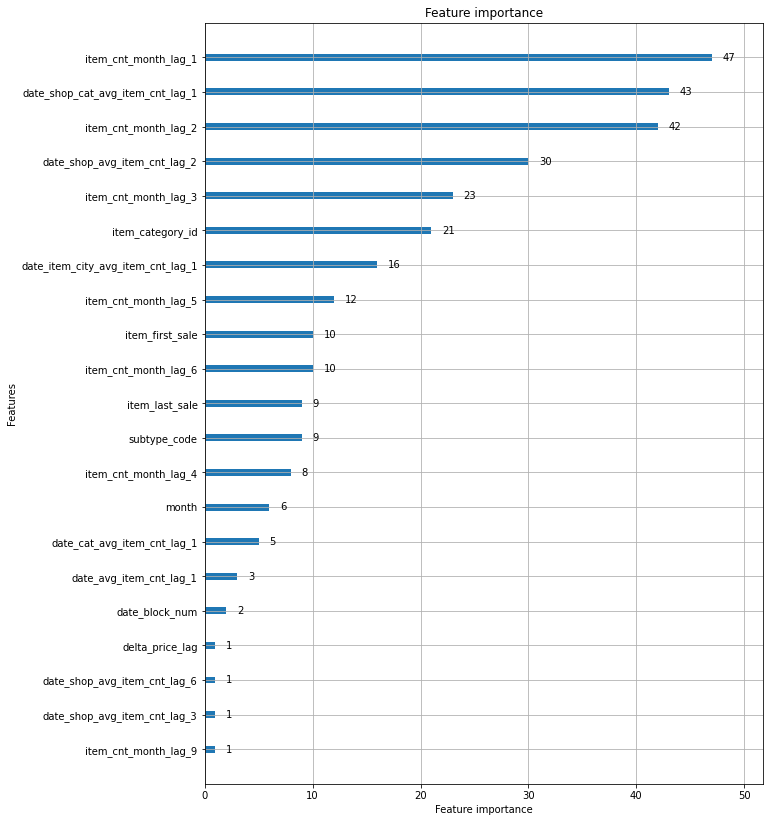

In [25]:
#importance = pd.DataFrame(model.feature_importance(), index=X_train.columns, columns=['importance'])
fig, ax = plt.subplots(1,1,figsize=(10, 14))
lgb.plot_importance(booster=model, ax=ax)